## Downloading and processing BARPA data

In this tutorial, we will use the DLWP data module to fetch and pre-process data from ERA5 to use in a DLWP weather prediction model. For the sake of simplicity, we use only a select few variables over a few years.

#### Python packages required here not in the base requirements

Let's start by installing the `cdsapi` package, which is required for retrieval of data. (See the README for packages already required for DLWP that need to also be installed.) Note that to use `cdsapi` you will need to register for an API key at CDS, following [their instructions](https://cds.climate.copernicus.eu/api-how-to).

In [ ]:
#%conda install -c conda-forge cdsapi

In [1]:
from dask.distributed import Client
from datetime import datetime
client = Client(n_workers=12, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

<Client: 'tcp://127.0.0.1:41997' processes=12 threads=12, memory=376.55 GiB>

### Retrieve data

Define the variables and levels we want to retrieve. Single-level variables ignore the "levels" parameter. Also note that not all variables in the ERA5 dataset are coded with their parameter names as of now. We also take a reduced sample of years in the dataset.

In [1]:
variables = ['geopotential', '2m_temperature']
#levels = [500]
levels = [250]
#years = list(range(2013, 2019))
years = list(range(2013, 2016))

Initialize the data retriever. You'll want to change the directory to where you want to save the files.

In [3]:
#import os
#os.chdir(os.pardir)
#from DLWP.data import ERA5Reanalysis

#data_directory = '/home/disk/wave2/jweyn/Data/ERA5'
#os.makedirs(data_directory, exist_ok=True)
#era = ERA5Reanalysis(root_directory=data_directory, file_id='tutorial')
#era.set_variables(variables)
#era.set_levels(levels)

import os
NOTEBOOK_PATH = "/scratch/fp0/mah900/DLWP-CS" 
os.chdir (f'{NOTEBOOK_PATH}')
from DLWP.data import ERA5Reanalysis

data_directory = '/g/data/wb00/admin/testing/DLWP/Data/BARPA'
os.makedirs(data_directory, exist_ok=True)
era = ERA5Reanalysis(root_directory=data_directory, file_id='BARPA')
era.set_variables(variables)
era.set_levels(levels)

Download data! Automatically uses multi-processing to retrieve multiple files at a time. Note the parameter `hourly` says we're retrieving only every 3rd hour in the data, which is available hourly. The optional parameter passed to the retrieval package specifies that we want data interpolated to a 2-by-2 latitude-longitude grid.

In [4]:
#era.retrieve(variables, levels, years=years, hourly=3,
#             request_kwargs={'grid': [2., 2.]}, verbose=True, delete_temporary=True)

import glob
import xarray as xr
#BARPA_variables = ['zg500', 'ts']
BARPA_variables = ['va250m', 'ts']
print (variables)
print (BARPA_variables)
#print (years)
all_files = []
DATAPATH = '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ERA5/evaluation/r1i1p1f1/BARPA-R/v1-r1/1hr'
for year in years:
    print (year)
    all_files += glob.glob (fr'{DATAPATH}/{BARPA_variables[0]}/v20231001/*{year}*' )
    all_files += glob.glob (fr'{DATAPATH}/{BARPA_variables[1]}/v20231001/*{year}*' )
    
#print (*all_files, sep="\n") 

Dataset = xr.open_mfdataset(all_files, chunks={'time': 10}, parallel = True, join='override') 
#print(Dataset)  
Dataset = Dataset.isel(time=slice(0, None, 3))
#print(raw_data)  
era.Dataset = Dataset
era.dataset_dates = era.Dataset['time']
#print(era.Dataset)


['geopotential', '2m_temperature']
['va250m', 'ts']
2013
2014
2015


/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


Check that we got what we wanted after the retrieval is done:

In [5]:
#era.open()
print(era.Dataset)

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 436, lon: 777)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
    height   float64 250.0
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(4, 436, 777), meta=np.ndarray>
    va250m   (time, lat, lon) float64 dask.array<chunksize=(4, 436, 777), meta=np.ndarray>
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    productive_version:        v1
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    ...                        ...
    history:                   Tue Oct 24 16:03:49 2023: /g/data/access/ngm/m...
    references:                https://doi.org/10.25914/z1x6-dq28
    license:                   htt

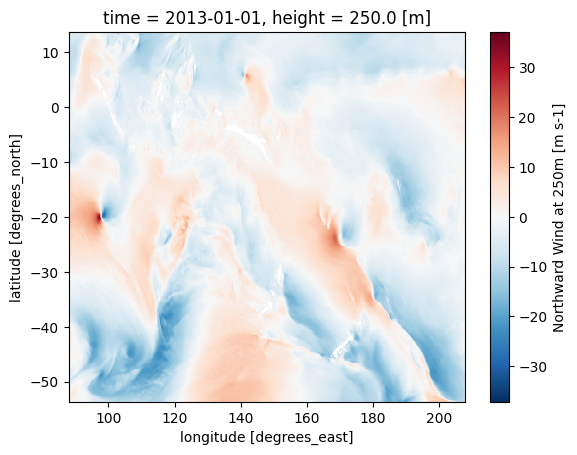

In [7]:
era.Dataset.va250m[0].plot()

### Process data for ingestion into DLWP

Now we use the DLWP.model.Preprocessor tool to generate a new data file ready for use in a DLWP Keras model. Some preliminaries... Note that we assign level "0" to the single-level 2m temperature data. I highly recommend using "pairwise" data processing, which means that each variable is matched to a level pair-wise. The length of the variables and levels lists should be the same. Also note that you only need to specify whole days in the dates. It takes care of the hourly data automatically.

In [6]:
import pandas as pd
from DLWP.data.era5 import get_short_name

#dates = list(pd.date_range('2013-01-01', '2018-12-31', freq='D').to_pydatetime())
#dates = list(pd.date_range('2013-01-01', '2016-12-31', freq='D').to_pydatetime())
dates = list(pd.date_range('2013-01-01', '2015-12-31', freq='D').to_pydatetime())
#variables = get_short_name(variables)
variables = BARPA_variables
#levels = [500, 0]
levels = [250, 0]
#processed_file = '%s/tutorial_z500_t2m.nc' % data_directory
processed_file = f'{data_directory}/BARPA_z500_t2m.nc'
print ('processed_file:',processed_file)

processed_file: /g/data/wb00/admin/testing/DLWP/Data/BARPA/BARPA_z500_t2m.nc


Process data! For proper use of data in a neural network, variables must be normalized relative to each other. This is typically done simply by removing mean and dividing by standard deviation (`scale_variables` option). To save on memory use, we normally calculate the global mean and std of the data in batches. Since this is a small dataset, we can use a large batch size to make it go faster.

In [7]:
%%time
from DLWP.model import Preprocessor

pp = Preprocessor(era, predictor_file=processed_file)
pp.data_to_series(batch_samples=10000, variables=variables, levels=levels, pairwise=True,
                  scale_variables=True, overwrite=True, verbose=True)

2024-03-06 03:00:41.752363: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 03:00:41.796883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Preprocessor.data_to_samples: opening and formatting raw data
Preprocessor.data_to_samples: creating output file /g/data/wb00/admin/testing/DLWP/Data/BARPA/BARPA_z500_t2m.nc
Preprocessor.data_to_samples: variable/level pair 1 of 2 (va250m/250)
Preprocessor.data_to_samples: calculating mean and std
Preprocessor.data_to_samples: writing batch 1 of 1
Preprocessor.data_to_samples: variable/level pair 2 of 2 (ts/0)
Preprocessor.data_to_samples: calculating mean and std
Preprocessor.data_to_samples: writing batch 1 of 1
CPU times: user 5min 5s, sys: 2min 44s, total: 7min 49s
Wall time: 15min 8s


Show our dataset, then clean up. We also save to a version with no string coordinates (might be needed for tempest-remap in the next tutorial).

In [8]:
print(pp.data)
pp.data.drop('varlev').to_netcdf(processed_file + '.nocoord')
era.close()
pp.close()

<xarray.Dataset>
Dimensions:     (lat: 436, lon: 777, varlev: 2, sample: 8760)
Coordinates:
  * lat         (lat) float32 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon         (lon) float32 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
  * varlev      (varlev) object 'va250m/250' 'ts/0'
  * sample      (sample) datetime64[ns] 2013-01-01 ... 2015-12-31T21:00:00
Data variables:
    predictors  (sample, varlev, lat, lon) float32 dask.array<chunksize=(1, 2, 436, 777), meta=np.ndarray>
    mean        (varlev) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    std         (varlev) float32 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    description:  Training data for DLWP
    scaling:      True
